## Trying a new approach
My linear regression model was not doing very well in the past 2 weeks. This might be due to the time in the day that I buy stocks or my model need more information to predict better. In this week, I want to try something that I've seen my classmates using: Stacked LSTM. 

### Stacked LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from pandas_datareader.data import DataReader

symbols = ["AAPL", "MSFT", "GOOG", "AMZN", "FB"]

stop = datetime.now()
start = datetime(stop.year-1, stop.month, stop.day)

for symbol in symbols:
    globals()[symbol] = DataReader(symbol, 'yahoo', start, stop)

Text(0.5, 1.0, 'AAPL Adj Close')

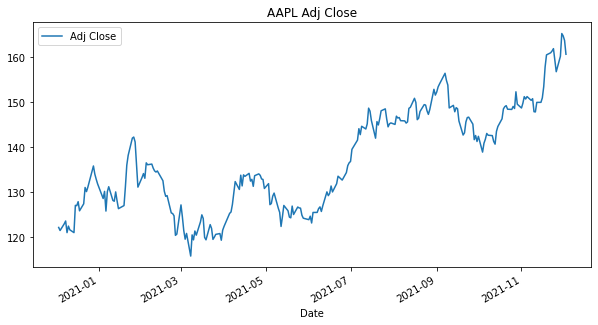

In [2]:
AAPL['Adj Close'].plot(legend = 1, figsize=(10,5))
plt.title('AAPL Adj Close')

Text(0.5, 1.0, 'MSFT Adj Close')

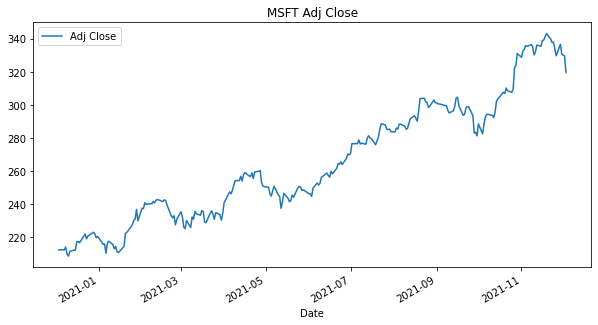

In [3]:
MSFT['Adj Close'].plot(legend = 1, figsize=(10,5))
plt.title('MSFT Adj Close')

Text(0.5, 1.0, 'GOOG Adj Close')

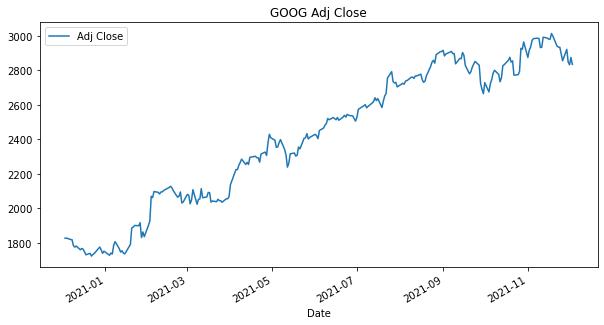

In [4]:
GOOG['Adj Close'].plot(legend = 1, figsize=(10,5))
plt.title('GOOG Adj Close')

Text(0.5, 1.0, 'AMZN Adj Close')

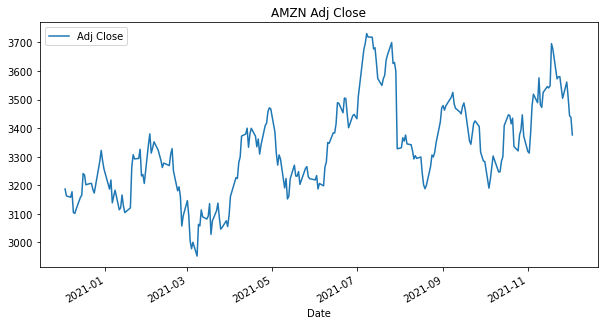

In [5]:
AMZN['Adj Close'].plot(legend = 1, figsize=(10,5))
plt.title('AMZN Adj Close')

Text(0.5, 1.0, 'FB Adj Close')

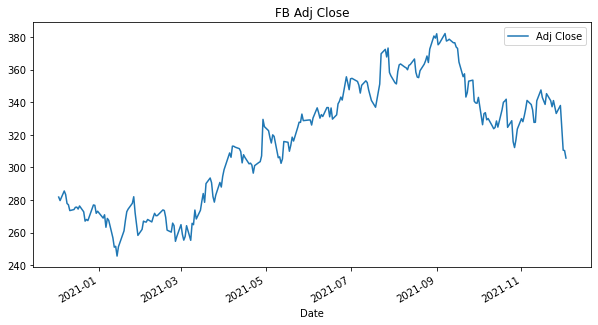

In [6]:
FB['Adj Close'].plot(legend = 1, figsize=(10,5))
plt.title('FB Adj Close')

In [10]:
import pandas_datareader as pdr

api_key = '37433789a0630adbec1815961d663c4c75b69e6c'

In [11]:
stock = 'AAPL'
df = pdr.get_data_tiingo(stock, api_key=api_key)

In [12]:
df.head()

close    high     low    open    volume  \
symbol date                                                                  
AAPL   2016-12-05 00:00:00+00:00  109.11  110.03  108.25  110.00  34324540   
       2016-12-06 00:00:00+00:00  109.95  110.36  109.19  109.50  26195462   
       2016-12-07 00:00:00+00:00  111.03  111.19  109.16  109.26  29998719   
       2016-12-08 00:00:00+00:00  112.12  112.43  110.60  110.86  27068316   
       2016-12-09 00:00:00+00:00  113.95  114.70  112.31  112.31  34402627   

                                   adjClose    adjHigh     adjLow    adjOpen  \
symbol date                                                                    
AAPL   2016-12-05 00:00:00+00:00  25.672732  25.889200  25.470380  25.882142   
       2016-12-06 00:00:00+00:00  25.870377  25.966847  25.691555  25.764496   
       2016-12-07 00:00:00+00:00  26.124493  26.162139  25.684496  25.708025   
       2016-12-08 00:00:00+00:00  26.380961  26.453902  26.023317  26.084493   
       2016-12-09 00:00:00+00:00  26.811546  26.988015  26.425667  26.425667   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
AAPL   2016-12-05 00:00:00+00:00  137298160      0.0          1.0  
       2016-12-06 00:00:00+00:00  104781848      0.0          1.0  
       2016-12-07 00:00:00+00:00  119994876      0.0          1.0  
       2016-12-08 00:00:00+00:00  108273264      0.0          1.0  
       2016-12-09 00:00:00+00:00  137610508      0.0          1.0

In [13]:
close_price = df.reset_index()['close']

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
close_price = scaler.fit_transform(np.array(close_price).reshape(-1,1))

close_price

array([[0.00568566],
       [0.00778961],
       [0.01049468],
       ...,
       [0.14642455],
       [0.14509706],
       [0.14256731]])

In [15]:
training_size = int(len(close_price)*.65)
test_size = len(close_price) - training_size
train_data = close_price[0:training_size,:]
test_data = close_price[training_size:len(close_price),:1]

In [16]:
def create_dataset(dataset, time_step = 1):
    datax, datay = [], []
    for i in range(len(dataset) - time_step -1):
        a = dataset[i:(i+time_step), 0]
        datax.append(a)
        datay.append(dataset[i + time_step, 0])
    return np.array(datax), np.array(datay)

#train test split
time_step = 100 #number of features
train_x, train_y = create_dataset(train_data, time_step)
test_x, test_y = create_dataset(test_data, time_step)

In [17]:
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1] , 1)
test_x = test_x.reshape(test_x.shape[0],test_x.shape[1] , 1)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) 
model.add(LSTM(50,return_sequences=True))#stacked
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 8s 101ms/step - loss: 0.0196 - val_loss: 0.0228
Epoch 2/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0039 - val_loss: 0.0254
Epoch 3/100
12/12 [==============================] - 0s 24ms/step - loss: 0.0019 - val_loss: 0.0187
Epoch 4/100
12/12 [==============================] - 0s 21ms/step - loss: 8.8777e-04 - val_loss: 0.0218
Epoch 5/100
12/12 [==============================] - 0s 21ms/step - loss: 7.0507e-04 - val_loss: 0.0241
Epoch 6/100
12/12 [==============================] - 0s 24ms/step - loss: 5.9744e-04 - val_loss: 0.0208
Epoch 7/100
12/12 [==============================] - 0s 23ms/step - loss: 5.8986e-04 - val_loss: 0.0219
Epoch 8/100
12/12 [==============================] - 0s 22ms/step - loss: 5.6164e-04 - val_loss: 0.0210
Epoch 9/100
12/12 [==============================] - 0s 21ms/step - loss: 5.4871e-04 - val_loss: 0.0198
Epoch 10/100
12/12 [==============================] - 0s 21ms/step - loss: 

In [20]:
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

import math

from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(train_y,train_predict))

206.41083114396653

In [21]:
math.sqrt(mean_squared_error(test_y,test_predict))

182.2713541777338

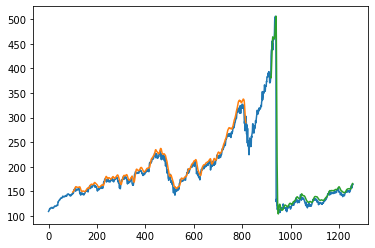

In [22]:
look_back=100
trainPredictPlot = np.empty_like(close_price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(close_price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_price) - 1, :] = test_predict

plt.plot(scaler.inverse_transform(close_price))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [23]:
from numpy import array

num = len(test_data) - 100

x_input = test_data[num:].reshape(1,-1)
x_input.shape #check

(1, 100)

In [24]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist() 

In [25]:
lst_output = []
n_steps = 100
i = 0
while(i < 7):
    
    if(len(temp_input) > 100):

        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        y_pred = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,y_pred))
        temp_input.extend(y_pred[0].tolist())
        temp_input = temp_input[1:]
        
        lst_output.extend(y_pred.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        y_pred = model.predict(x_input, verbose=0)
        print(y_pred[0])
        temp_input.extend(y_pred[0].tolist())
        print(len(temp_input))

        lst_output.extend(y_pred.tolist()) 
        i = i + 1
    

print(lst_output)

[0.15141931]
101
1 day input [0.10429555 0.09906074 0.08919224 0.09845961 0.09658109 0.10008766
 0.10449593 0.10557295 0.10001252 0.09552912 0.09718222 0.09773325
 0.09688165 0.10149029 0.10046337 0.10073889 0.09843456 0.09830933
 0.09708203 0.09773325 0.10532248 0.10584847 0.11090795 0.10857858
 0.0989856  0.09983719 0.10356919 0.10737633 0.10715091 0.10399499
 0.10194114 0.10459612 0.11591735 0.11268629 0.11438948 0.11724483
 0.11887289 0.12485911 0.12090169 0.11829681 0.10552286 0.10697558
 0.10339386 0.10567314 0.10507201 0.09823419 0.09041954 0.09164684
 0.0977082  0.10016281 0.10038823 0.09650595 0.0878397  0.09014402
 0.08681277 0.08969317 0.08090169 0.08583594 0.08806512 0.09129618
 0.09031935 0.09009393 0.08683782 0.085335   0.09247339 0.09517846
 0.09946149 0.10499687 0.10624922 0.10680025 0.10482154 0.10469631
 0.1063995  0.10522229 0.11453976 0.10760175 0.10549781 0.10815279
 0.11183469 0.1105072  0.1113087  0.10920476 0.1101315  0.10289292
 0.10276769 0.10807765 0.10810269

In [26]:
new_day = np.arange(1,101)
prediction_day = np.arange(101,108)

len(close_price)

1258

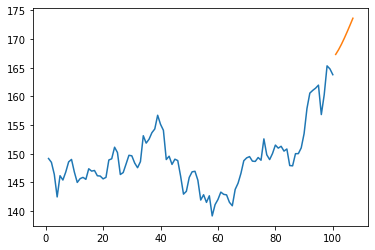

In [27]:
num = len(close_price) - 100

plt.plot(new_day,scaler.inverse_transform(close_price[num:]))
plt.plot(prediction_day,scaler.inverse_transform(lst_output))

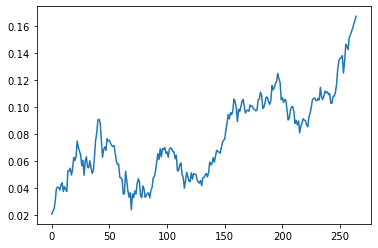

In [28]:
predict = close_price.tolist()
predict.extend(lst_output) #adding output to end
plt.plot(predict[1000:])

### Linear Regression
Just like what I did in the previous week.

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

symbols = ["AAPL", "MSFT", "GOOG", "AMZN", "FB"]

predicted_list = []
latest_close_list = []

for symbol in symbols:
    # Download data
    data_1d = yf.download(symbol, start="2016-01-01", end="2021-12-03")

    # Preprocess data
    tmp = data_1d[["Adj Close"]]
    tmp["mean_5"] = tmp["Adj Close"].shift(1).rolling(window=5).mean()
    tmp["mean_10"] = tmp["Adj Close"].shift(1).rolling(window=10).mean()
    tmp = tmp.dropna()
    x = tmp[["mean_5", "mean_10"]]
    y = tmp[["Adj Close"]]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    # Apply model
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Use model to predict 
    tmp = data_1d[["Adj Close"]][-10:]
    tmp.loc[tmp.shape[0]] = [0]
    tmp["mean_5"] = tmp["Adj Close"].shift(1).rolling(window=5).mean()
    tmp["mean_10"] = tmp["Adj Close"].shift(1).rolling(window=10).mean()
    tmp = tmp.dropna()
    tmp = tmp[["mean_5", "mean_10"]]

    predicted = float(model.predict(tmp))
    predicted_list.append(predicted)
    latest_close = float(data_1d["Adj Close"][-1:])
    latest_close_list.append(latest_close)

In [30]:
predicted_change_list = []
percent_change_list = []
print("Predicted adjusted close price:")
for i, symbol in enumerate(symbols):
    predicted_change_list.append( predicted_list[i] - latest_close_list[i] )
    percent_change_list.append(predicted_change_list[i] / latest_close_list[i])
    print(
        f"{symbol}: {predicted_list[i]} - Predicted change: {round(predicted_change_list[i], 3)} ({round(percent_change_list[i], 4)}%)"
        )

Predicted adjusted close price:
AAPL: 162.9131688299717 - Predicted change: -0.847 (-0.0052%)
MSFT: 330.29188213365535 - Predicted change: 0.802 (0.0024%)
GOOG: 2855.6291166808887 - Predicted change: -19.901 (-0.0069%)
AMZN: 3468.6495299504368 - Predicted change: 31.289 (0.0091%)
FB: 320.2187444587363 - Predicted change: 9.829 (0.0317%)


## Decision
The stock market is not doing very well this week, so I only buy very small amount of MSFT, FB, and AAPL since their predicted price and trend seems not too bad at the time I was buying.

**Final Result (Buy):**

| Symbol | QTY | Purchase Price | Close Price |
| :--- | :---  | :--- | :---  |
| MSFT | 1 | 318.93 | 323.01 |
| FB | 1 | 304.66 | 306.84 |
| AAPL | 3 | 159.84 | 161.84 |